# Finding maps (at scale) with computer vision and Jupyter notebooks (inference demo)

Author: Daniel van Strien <a itemprop="sameAs" content="https://orcid.org/0000-0003-1684-6556" href="https://orcid.org/0000-0003-1684-6556" target="orcid.widget" rel="me noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon">https://orcid.org/0000-0003-1684-6556</a>

Credit: *This project, funded by the UK Research and Innovation (UKRI) Strategic Priority Fund, is a multidisciplinary collaboration delivered by the Arts and Humanities Research Council (AHRC), with The Alan Turing Institute, the British Library and the Universities of Cambridge, East Anglia, Exeter, and Queen Mary University of London.*

In [1]:
pip install light-the-torch

     |████████████████████████████████| 1.5MB 10.6MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [2]:
!ltt install torch torchvision

     |████████████████████████████████| 735.3 MB 21 kB/s 
     |████████████████████████████████| 12.8 MB 51 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [3]:
!pip install -q fastai --upgrade

     |████████████████████████████████| 188 kB 9.6 MB/s 
     |████████████████████████████████| 45 kB 3.6 MB/s 


In [4]:
import torch


In [5]:
torch.cuda.is_available()

True

In [6]:
!wget -q -O newspaper_maps.zip https://zenodo.org/record/4156510/files/newspaper_maps.zip?download=1
!unzip -q newspaper_maps.zip

In [7]:
!wget -O map_labels.csv https://zenodo.org/record/4156510/files/map_labels.csv?download=1

--2020-11-03 08:21:07--  https://zenodo.org/record/4156510/files/map_labels.csv?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22267 (22K) [text/plain]
Saving to: ‘map_labels.csv’

map_labels.csv      100%[===================>]  21.75K  --.-KB/s    in 0.02s   

2020-11-03 08:21:07 (1018 KB/s) - ‘map_labels.csv’ saved [22267/22267]



In [8]:
from fastai.vision.all import *

In [9]:
import fastai
fastai.__version__

'2.1.3'

We'll load our 200 labels into a dataframe

In [10]:
df_labels = pd.read_csv('map_labels.csv')

and create a new fastai dataloader

In [11]:
dls = ImageDataLoaders.from_df(df_labels, fn_col='fname', 
                               label_col='label',
                               valid_pct=0.3, 
                               item_tfms=Resize(256),
                               bs=16,num_workers=0)

In [12]:
learn = cnn_learner(dls,
                    resnet18, pretrained=True,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[F1Score(),accuracy, Precision(), Recall()]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


SuggestedLRs(lr_min=0.002754228748381138, lr_steep=6.309573450380412e-07)

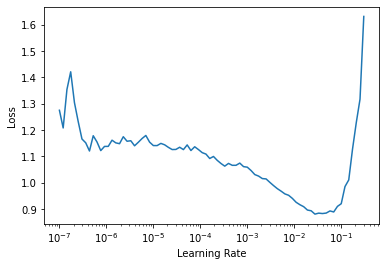

In [13]:
learn.lr_find()

In [14]:
learn.fit_one_cycle(30, 
                    lr_max=1e-3,
                    cbs=[SaveModelCallback(monitor='f1_score'),
                        ReduceLROnPlateau(monitor='f1_score', patience=9),
                        EarlyStoppingCallback(monitor='f1_score',patience=10),
                        MixUp()])

epoch,train_loss,valid_loss,f1_score,accuracy,precision_score,recall_score,time
0,1.203442,0.954552,0.451613,0.492537,0.560000,0.378378,00:34
1,1.164216,0.715707,0.640000,0.597015,0.631579,0.648649,00:33
2,1.056603,0.663454,0.776471,0.716418,0.687500,0.891892,00:33
3,1.012985,0.684040,0.791209,0.716418,0.666667,0.972973,00:33
4,0.950048,0.583721,0.857143,0.820895,0.765957,0.972973,00:33
5,0.890498,0.463949,0.871795,0.850746,0.829268,0.918919,00:33
6,0.871861,0.470884,0.885714,0.880597,0.939394,0.837838,00:33
7,0.848575,0.434854,0.901408,0.895522,0.941176,0.864865,00:33
8,0.830308,0.413449,0.885714,0.880597,0.939394,0.837838,00:33
9,0.816164,0.409027,0.916667,0.910448,0.942857,0.891892,00:34


Better model found at epoch 0 with f1_score value: 0.4516129032258065.
Better model found at epoch 1 with f1_score value: 0.64.
Better model found at epoch 2 with f1_score value: 0.7764705882352941.
Better model found at epoch 3 with f1_score value: 0.7912087912087912.
Better model found at epoch 4 with f1_score value: 0.8571428571428571.
Better model found at epoch 5 with f1_score value: 0.8717948717948718.
Better model found at epoch 6 with f1_score value: 0.8857142857142858.
Better model found at epoch 7 with f1_score value: 0.9014084507042254.
Better model found at epoch 9 with f1_score value: 0.9166666666666667.
Better model found at epoch 16 with f1_score value: 0.935064935064935.
Better model found at epoch 18 with f1_score value: 0.9577464788732395.
Epoch 27: reducing lr to 2.15748265956512e-06
No improvement since epoch 18: early stopping


In [15]:
learn.save('stage-1')

Path('models/stage-1.pth')

SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=8.31763736641733e-06)

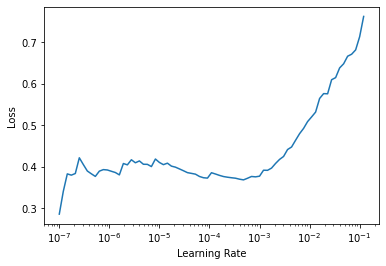

In [16]:
learn.unfreeze()
learn.lr_find()

In [17]:
learn.fit_one_cycle(5, 
                    lr_max=slice(1e-6,1e-5),
                    cbs=[SaveModelCallback(monitor='f1_score'),
                        ReduceLROnPlateau(monitor='f1_score', patience=1),
                        EarlyStoppingCallback(monitor='f1_score',patience=2),
                        MixUp()])

epoch,train_loss,valid_loss,f1_score,accuracy,precision_score,recall_score,time
0,0.593006,0.334555,0.944444,0.940298,0.971429,0.918919,00:34
1,0.596432,0.324248,0.931507,0.925373,0.944444,0.918919,00:34
2,0.576864,0.335045,0.942857,0.940298,1.000000,0.891892,00:34


Better model found at epoch 0 with f1_score value: 0.9444444444444445.
Epoch 1: reducing lr to 9.300752614405173e-07
Epoch 2: reducing lr to 5.982622552032472e-07
No improvement since epoch 0: early stopping


In [18]:
interp = ClassificationInterpretation.from_learner(learn)

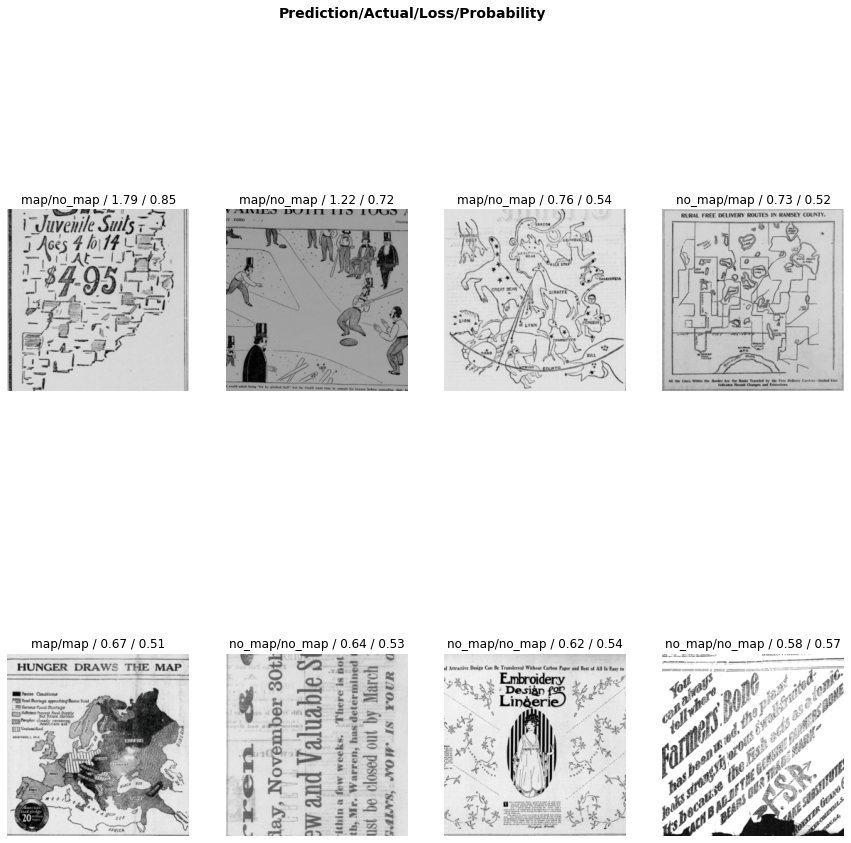

In [19]:
interp.plot_top_losses(8,figsize=(15,15))

## 🤖 Using International Image Interoperability Framework (IIIF) to predict maps at scale

In [75]:
import pandas as pd
df = pd.read_json('inference_maps.json')

We can see how many potential images we have in this dataset

In [39]:
df = df.reset_index(drop=True)

In [40]:
len(df)

10000

## ‼️ Dealing with missing images
One slight challenge of doing our predictions in this way is that we may sometimes request an image that isn't available. This could be because for some reason it hasn't been included in the IIIF collections, or because we have a temporary network issue etc. We need to account for this when we try and load our image. A fairly simple way to do this is to adapt our previous `load_image` command to include a try/except block. 

If you aren't familiar with Python/coding a try/except block as the name suggests, is a way in which you can deal with failure in your code, by trying to do something, and 'excepting' a potential outcome. You can deal with this in different ways in this case we'll just say that the image is `None`

In [26]:
import PIL

In [27]:
def load_image(url):
    with requests.get(url) as r:
        try:     
            img = PILImage.create(io.BytesIO(r.content))
        except PIL.UnidentifiedImageError:
            img = None
    return img

We're almost to the point we can start predicting at scale, on more small digression...

In [28]:
from tqdm.auto import tqdm

## 🤖 A small love letter to progress bars 

It is probably not a surprise that working with larger collections of images takes longer. When things take a few seconds we don't necessarily need to know if it's going to take two seconds or 1 second. However when things start taking minutes, hours or days it might be nice to get an ETA on when things are going to be finished. 

One way of getting some estimated time remaining is to use a progress bar. There are different options available in Python but one nice option is [tqdm](https://github.com/tqdm/tqdm). It is simple to use to start with but also includes options to customize how it works if you need more flexibility. To get started with tqdm you can 'wrap' it around any iterable (something you can loop over in Python). You can also pass in a variable `total` if you know how many total items are to be processed. 

Although using tqdm might not be so important in this example it can be useful for giving you some sense of how long something will take, and potentially stopping things early if you think it's running to slowly.

## 🤖 Making predictions from our DataFrame 

In this next section we see one possible way of combining what we have already seen to run predictions at scale. This example isn't intended to be fully optimized but is intended to illustrate a simple approach to using IIIF to make predictions using our image classifier. 

This code is commented out by default, since we don't want to run it more than we have to, especially in a workshop context. 

In [52]:
labels = [] # we create a list to store our predictions 
probs = []
for t in tqdm(df.itertuples(), total=len(df)): # we loop through our dataframe one row at a time
    url = t.iiif_url # we get the iiif url for each row
    im = load_image(url) # we try and load an image from this url
    if im: # if we get back an image we use our model to make a prediction 
        with learn.no_bar():
            label,_, prob = learn.predict(im)
    else: # if we don't get an image we print the url 
        tqdm.write(f'no image found at {url}')
        label = np.NaN # and assign NaN for that image (i.e a missing value)
        prob = np.NaN
    labels.append(label) # we add our prediction to the predictions list
    probs.append(prob)

no image found at https://chroniclingamerica.loc.gov/iiif/2/in_darrow_ver02%2Fdata%2Fsn82015313%2F00383348730%2F1923091901%2F0201.jp2/pct:3.75,46.16,47.71,39.57/pct:50/0/default.jpg
no image found at https://chroniclingamerica.loc.gov/iiif/2/in_darrow_ver02%2Fdata%2Fsn82015313%2F0038334881A%2F1925010301%2F0039.jp2/pct:15.36,4.7,22.12,19.42/pct:50/0/default.jpg
no image found at https://chroniclingamerica.loc.gov/iiif/2/ak_harborseal_ver02%2Fdata%2Fsn2008058232%2F00279525814%2F1915082401%2F0566.jp2/pct:26.11,55.89,28.94,32.08/pct:50/0/default.jpg
no image found at https://chroniclingamerica.loc.gov/iiif/2/ak_harborseal_ver02%2Fdata%2Fsn2008058232%2F00279525826%2F1916012801%2F0615.jp2/pct:37.35,44.77,30.82,35.19/pct:50/0/default.jpg
no image found at https://chroniclingamerica.loc.gov/iiif/2/in_darrow_ver02%2Fdata%2Fsn82015313%2F00383348808%2F1924120301%2F0372.jp2/pct:37.92,61.68,23.43,27.24/pct:50/0/default.jpg
no image found at https://chroniclingamerica.loc.gov/iiif/2/ak_harborseal_ve

In [76]:
df['probs'] = probs

In [77]:
 df['label'] = labels

In [78]:
df['map_prob'] = df['probs'].str[0].apply(lambda x: float(x))
df['no_map_prob'] = df['probs'].str[1].apply(lambda x: float(x))

In [81]:
df = df.drop(columns='probs')

In [82]:
df.to_json('maps_preds_10000.json')